<a href="https://colab.research.google.com/github/MariaLavrovskaya/LGD-predictions/blob/main/cat_boost_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool, cv, metrics

# data = pd.read_excel('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/LGD_Data_pass.xlsx')


In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Aug  8 13:41:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# exporting the file
from google.colab import files
uploaded = files.upload()

Saving LGD_Data_pass.xlsx to LGD_Data_pass.xlsx


In [8]:
import io
data = pd.read_excel(io.BytesIO(uploaded['LGD_Data_pass.xlsx']))

### Preprocessing stage

In [9]:
# Quick data cleaning, dropped ranges for now
data = data.drop(['Act_endg_upb', 'flag_mod', 'stepmod_ind', 'dpm_ind', 'eltv', 'disaster_area_flag', 'borr_assist_ind', 'vintage',
                  'lag_id_loan', 'delq_string', 'month_string'], axis=1)

In [10]:
# Treating NaN values
data.isnull().any()
data=data.dropna()

In [11]:
max(data['LGD'])

1.357

In [12]:
import numpy as np
#Drop all the datetime columns for now
data.columns.to_series().groupby(data.dtypes).groups
# data = data.drop(['Period', 'Dt_zero_BAL', 'Dt_Lst_Pi', 'prior_period', 'orign_qtr', 'dt_first_pi'], axis=1)
# All LGD > 1 we convert to 1
data['LGD'] = np.where(data.LGD > 1, 1, data.LGD)

In [13]:
data

ID_loan  Period  delq_sts  ...  orig_loan_term  cnt_borr    LGD
0     F111Q1001064  201907         0  ...             360         1  0.265
1     F111Q1004260  201306        16  ...             360         1  0.162
2     F111Q1004580  201305         2  ...             360         1  0.000
3     F111Q1004663  201208        10  ...             360         1  0.057
4     F111Q1004665  201207        10  ...             360         2  0.049
...            ...     ...       ...  ...             ...       ...    ...
1050  F111Q2240130  201407        15  ...             360         1  0.074
1051  F111Q2244003  201906         0  ...             360         1  0.817
1052  F111Q2244349  201312        13  ...             360         1  0.957
1053  F111Q2245120  201512        42  ...             300         2  0.579
1055  F111Q2247366  201712        63  ...             360         2  0.370

[908 rows x 60 columns]

In [14]:
# Converting years and months
from IPython.display import clear_output
clear_output()
# data['Period'] = pd.to_datetime(data['Period'], format='%Y%m')
# data['Dt_zero_BAL'] = pd.to_datetime(data['Dt_zero_BAL'], format='%Y%m')
# data['Dt_Lst_Pi'] = pd.to_datetime(data['Dt_Lst_Pi'], format='%Y%m')
# data['prior_period'] = pd.to_datetime(data['prior_period'], format='%Y%m')
# data['dt_first_pi'] = pd.to_datetime(data['dt_first_pi'], format='%Y%m')
# Converting quarters 
intr = data['orign_qtr'].str.replace(r'(Q\d)(\d+)', r'\2-\1')
data['orign_qtr'] = pd.PeriodIndex(intr, freq='Q').to_timestamp()


In [15]:
# Separating into X and y
X = data.drop(columns = ['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds'], axis=1)
y = data['LGD']

### Explanatory

In [16]:
import matplotlib as mpl
plt.style.use(['seaborn-white', 'fivethirtyeight'])
mpl.rcParams['lines.linewidth'] = 2
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({
    "text.usetex": False})
%matplotlib inline

Text(0, 0.5, 'Count')

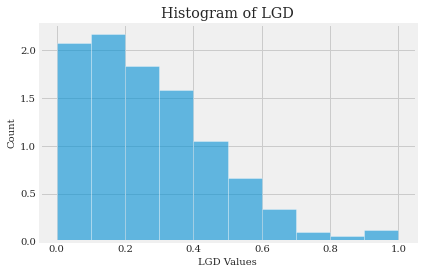

In [17]:
n, bins, _ = plt.hist(y, bins=10, density=True, alpha = 0.6, linewidth=0.5, edgecolor='white')
plt.title('Histogram of LGD')
plt.xlabel('LGD Values', {'fontsize':'medium'})
plt.ylabel('Count', {'fontsize':'medium'})

In [18]:
list(set(data.dtypes.tolist()))

[dtype('int64'), dtype('<M8[ns]'), dtype('O'), dtype('float64')]

In [23]:
df_num = data.select_dtypes(include = ['float64', 'int64'])
df_num.head()

Period  delq_sts  loan_age  ...  cnt_borr    LGD  stratification
0  201907         0        99  ...         1  0.265             0.2
1  201306        16        28  ...         1  0.162             0.1
2  201305         2        27  ...         1  0.000             0.0
3  201208        10        18  ...         1  0.057             0.0
4  201207        10        17  ...         2  0.049             0.0

[5 rows x 50 columns]

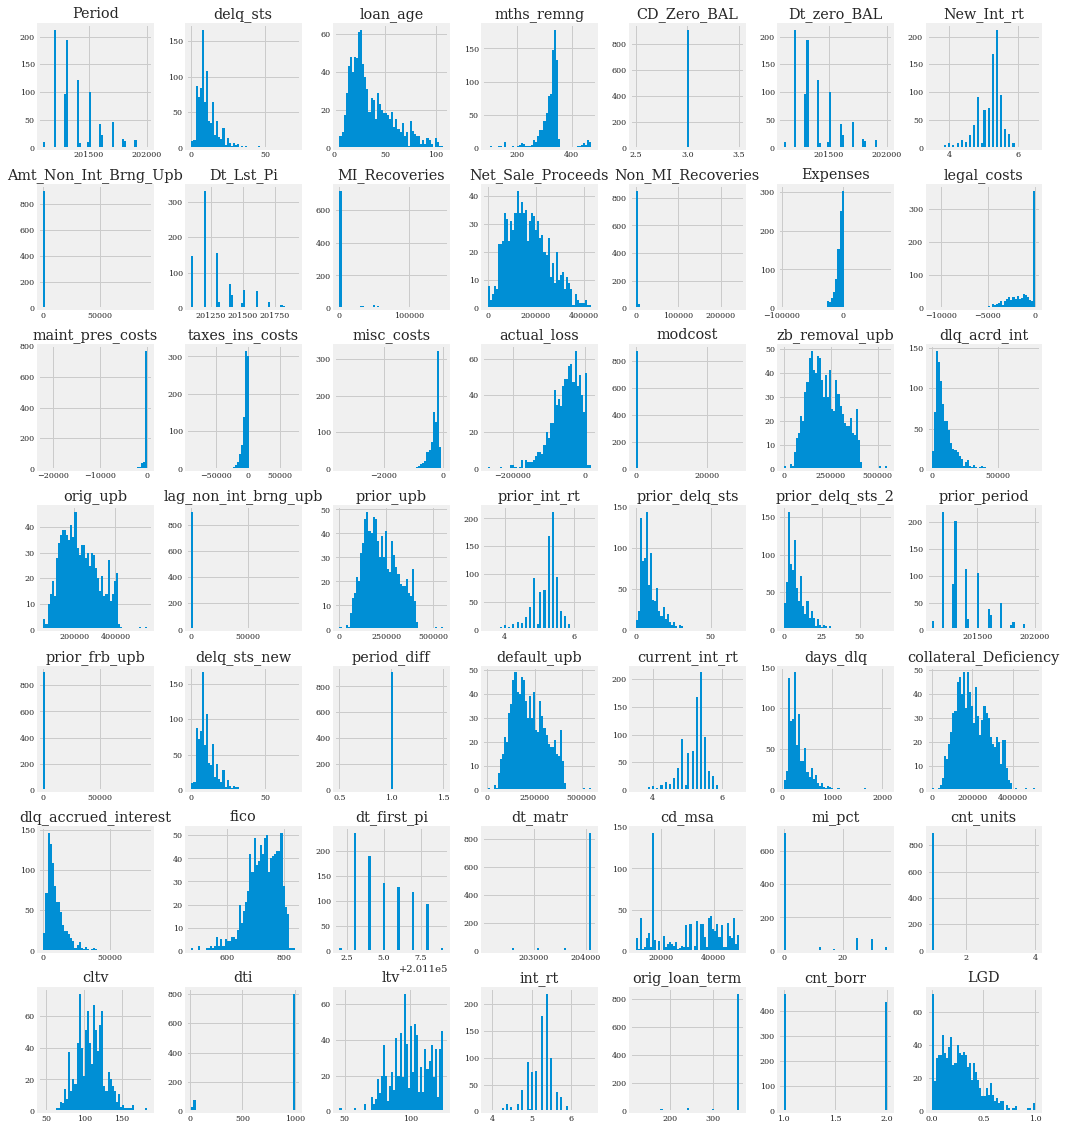

In [24]:
df_num.drop(['stratification'], axis=1).hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

Note: exclude variables with only one value: prior_delq_sts,  CD_Zero_Bal,


In [175]:
df_num_corr = df_num.corr(method ='spearman')['LGD'][:-1] # 
golden_features_list = df_num_corr[abs(df_num_corr) > 0.2].sort_values(ascending=False)
print("There is {} strongly correlated values with LGD:\n{}".format(len(golden_features_list), golden_features_list))

There is 18 strongly correlated values with LGD:
LGD                      1.000000
prior_delq_sts_2         0.298604
days_dlq                 0.298323
prior_delq_sts           0.298147
delq_sts_new             0.293376
delq_sts                 0.293376
misc_costs              -0.203751
maint_pres_costs        -0.230165
collateral_Deficiency   -0.259018
legal_costs             -0.263596
default_upb             -0.283854
prior_upb               -0.283854
zb_removal_upb          -0.283854
orig_upb                -0.292703
MI_Recoveries           -0.415544
mi_pct                  -0.419982
Net_Sale_Proceeds       -0.514130
actual_loss             -0.827012
Name: LGD, dtype: float64


In [112]:
data['delq_sts'].unique

<bound method Series.unique of 0        0
1       16
2        2
3       10
4       10
        ..
1050    15
1051     0
1052    13
1053    42
1055    63
Name: delq_sts, Length: 908, dtype: int64>

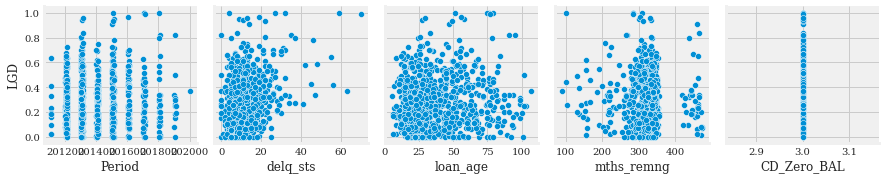

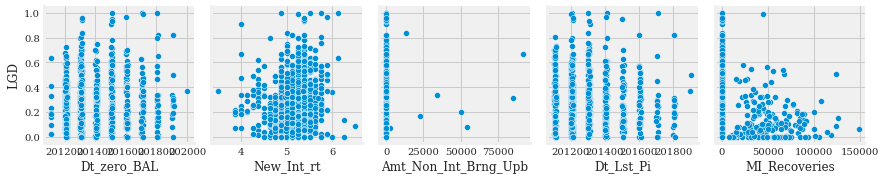

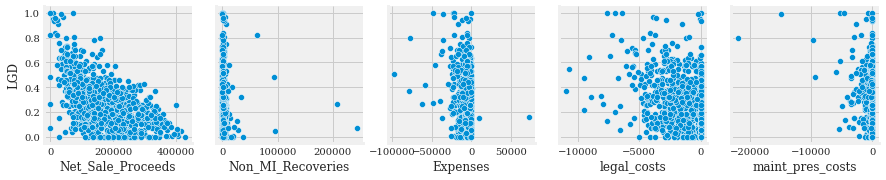

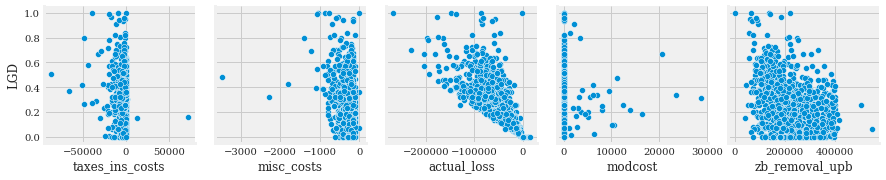

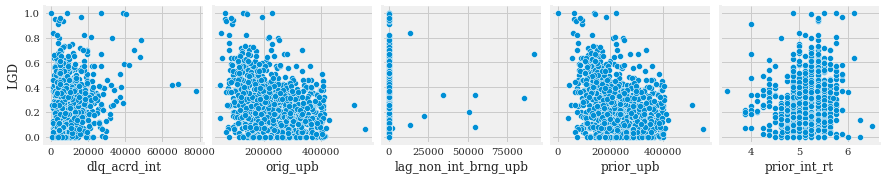

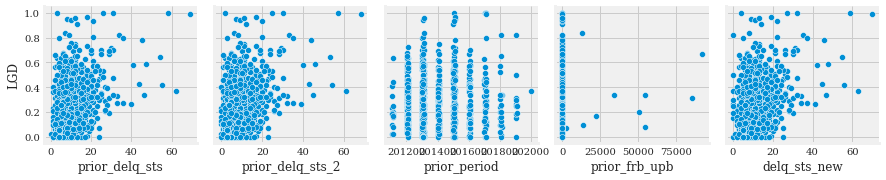

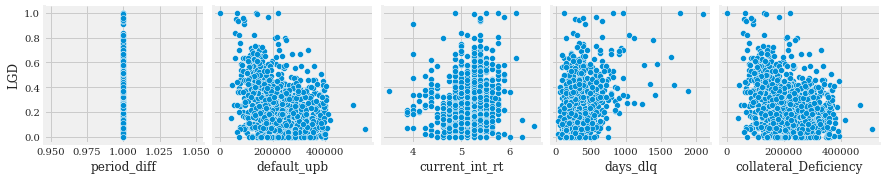

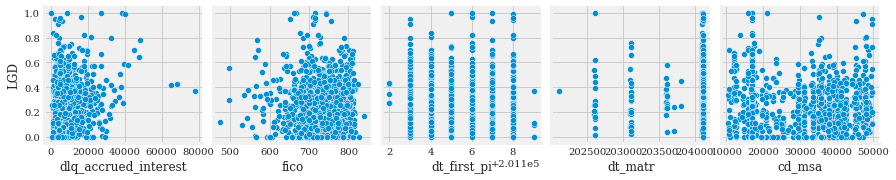

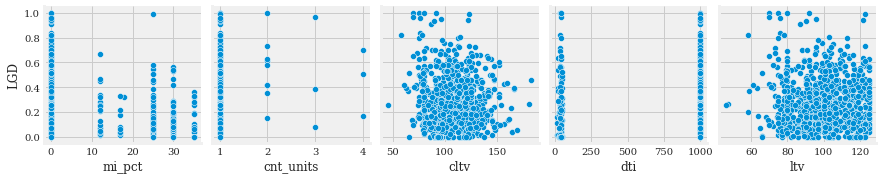

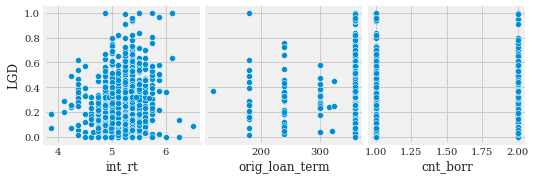

In [26]:
import seaborn as sns
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num.drop(['stratification'], axis=1),
                x_vars=df_num.drop(['LGD','stratification'], axis=1).columns[i:i+5],
                y_vars=['LGD'])

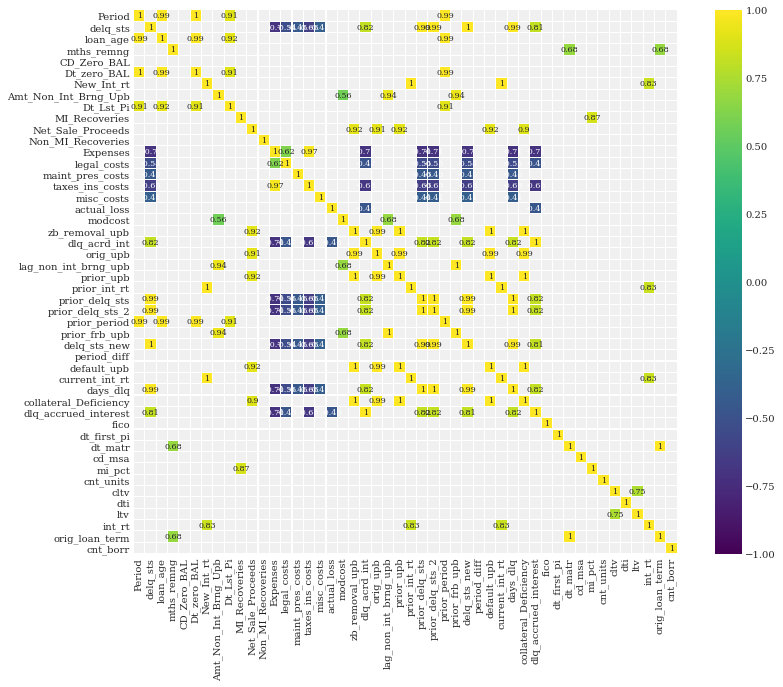

In [91]:
corr = df_num.drop(['LGD', 'stratification'], axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

### Gradient Boosting Regressor
The regressor uses RMSE as a loss function. This is the baseline model set to test the performance of the methods in question. The gridsearch of the hyperparameters has not been performed yet. 

The date-time variables have been dropped for now, yet they are to be considered in the future.

In [246]:
[print(element) for element in enumerate(data.columns)]
clear_output()

In [21]:
#create extra column that would allow to do split in stratified fashion, bins are taken from the histogram

data['stratification'] = 0
for index in range(len(bins)):
    data['stratification'] = np.where(data.LGD > bins[index], bins[index], data.stratification)

In [252]:
#Quick model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
X = data.drop(columns = ['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds'], axis=1)
# y = data['LGD']
# stratified fashion
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=0, stratify = data['stratification'] )
X_train1, X_val, y_train1, y_val  = train_test_split(X_train1, y_train1, test_size=0.25, random_state=1, stratify = X_train1['stratification'] ) # 0.25 x 0.8 = 0.2
# dropping the columns of 'stratification'
X_train1 = X_train1.drop(columns = ['stratification'], axis=1)
X_test1 = X_test1.drop(columns = ['stratification'], axis=1)
X_val = X_val.drop(columns = ['stratification'], axis=1)

# not stratified fashion
# X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=0)
# categorical features of the model
cat_features = ['loan_purpose', 'prop_type', 'st', 'prod_type', 'ppmt_pnlty', 'channel', 'occpy_sts', 'occpy_sts', 'flag_fthb',
               'CD_Zero_BAL']
# Creating Pool
train_dataset = Pool(data = X_train1, label=y_train1, cat_features=cat_features)
test_dataset = Pool(data = X_test1, label=y_test1, cat_features=cat_features)
eval_dataset = Pool(data = X_val, label=y_val, cat_features = cat_features )


# params metadata
param = {'bagging_temperature': 0,
 'bootstrap_type': 'Bayesian',
 'depth': 2,
 'l2_leaf_reg': 7,
 'learning_rate': 0.02,
 'max_leaves': 3,
 'score_function': 'NewtonL2'}
#delq_string should be tranformed to list, month_string should be transformed to list of dates 
model = CatBoostRegressor(iterations=2000,
                          # custom_loss=[metrics.RMSE()],
                          eval_metric = 'R2',
                          
                          learning_rate=0.02,
                          # eval_metric='R2',
                          use_best_model = True, 
                          early_stopping_rounds = 200,
                          bootstrap_type = 'Bayesian',
                          bagging_temperature = 0,
                                # save_snapshot=True,
                                # snapshot_interval=1600, 
                                # snapshot_file = '/content/drive/My Drive/Model results/gridsearch_04_08_00/snapshots.cbsnapshot',
                          grow_policy = 'SymmetricTree', 
                          ignored_features = [20, 51, 8, 37,6, 30, 27, 13],
                          # max_leaves = 3,
                          leaf_estimation_method = 'Newton',
                          # leaf_estimation_backtracking = 'Armijo',
                          boosting_type = 'Plain',
                          logging_level='Silent',
                          task_type = 'CPU',
                          score_function = 'L2',
                          depth=2,
                          l2_leaf_reg= 7,
                          # train_dir= '/content/drive/My Drive/Model results/model_results_05_08_03')
                          # quantization parameters
                          border_count = 270,
                          feature_border_type = 'MinEntropy', 
                          one_hot_max_size=10,
                          # monotonicity constraints
                          monotone_constraints = {'44':-1, '28':1, '23':-1}
                          )


# Fit model
model.fit(train_dataset, eval_set = eval_dataset, plot=True)
# Get predictions
preds = model.predict(test_dataset)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [253]:
model.tree_count_

927

In [254]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


# adjusted R^2 function

# def adj_r2(y_test1, preds):
#     return 1-(1-r2_score(y_test1, preds))*((len(X_test1)-1)/(len(X_test1)-len(X_test1.columns)-1))

def adj_r2(X_actual_test, y_actual_test, predictions):
    return 1-(1-r2_score(y_actual_test, predictions))*((len(X_actual_test)-1)/(len(X_actual_test)-len(X_actual_test.columns)-1))

#Training  results without any hyper search with RMSE as the loss function
#Huber loss with delta = 0.1, learning rate = 0.02, iterations = 20000, Cosine score function
print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, model.predict(train_dataset)))
print('Training: R^2 of the model', r2_score(y_train1, model.predict(train_dataset)))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, model.predict(train_dataset)))))
print('Training: MSE of the model', mean_squared_error(y_train1, model.predict(train_dataset)))

Training: Adjusted R^2 0.6124207298117393
Training: R^2 of the model 0.6556664168011663
Training: RMSE of the model 0.11648648365516408
Training: MSE of the model 0.013569100874344809


In [255]:
rmse = (np.sqrt(mean_squared_error(y_test1, preds)))
r2 = r2_score(y_test1, preds)
print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, preds))
print('Testing: R^2 of the model', r2)
print('Testing: RMSE of the model', rmse)
print('Testing: MSE of the model', mean_squared_error(y_test1, preds))

Testing: Adjusted R^2 0.4064054122010997
Testing: R^2 of the model 0.5220690635001501
Testing: RMSE of the model 0.13473347540033195
Testing: MSE of the model 0.01815310939345186


In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 908 entries, 0 to 1055
Data columns (total 61 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID_loan                908 non-null    object        
 1   Period                 908 non-null    int64         
 2   delq_sts               908 non-null    int64         
 3   loan_age               908 non-null    int64         
 4   mths_remng             908 non-null    int64         
 5   repch_flag             908 non-null    object        
 6   CD_Zero_BAL            908 non-null    int64         
 7   Dt_zero_BAL            908 non-null    int64         
 8   New_Int_rt             908 non-null    float64       
 9   Amt_Non_Int_Brng_Upb   908 non-null    float64       
 10  Dt_Lst_Pi              908 non-null    float64       
 11  MI_Recoveries          908 non-null    float64       
 12  Net_Sale_Proceeds      908 non-null    float64       
 13  Non_

In [ ]:
# Saving model to JSON files
import datetime
# pool = Pool(
#     data=X.drop(columns = ['stratification'], axis=1),
#     label=y,
#     cat_features=cat_features,
#     # feature_names=list(X.columns), 
# )


model.save_model(
    '/content/drive/My Drive/Model results/model_results_04_08_06/model-trained-on-{file_name}.json'.format(file_name=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")), #path to the model with datetime
    format="json",
    pool=train_dataset  # training dataset that is previously used for training
)

In [ ]:
print(model.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'RMSE', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 15000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'od_pval': 0, 'counter_calc_method': 'SkipTest', 'grow_policy': 'Lossguide', 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'pinned_memory_bytes': '104857600', 'l2_leaf_reg': 5, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': True, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss_normalization': False, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorder

In [ ]:
# cross-validation 
from catboost import cv
params = {"iterations": 10000,
          "depth": 5,
          'learning_rate':0.02,
          'task_type' : 'GPU',
          "loss_function": "RMSE",
          "verbose": False}

scores = cv(train_dataset,
            params,
            fold_count=5, 
            plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [62]:
data.info

<bound method DataFrame.info of            ID_loan  Period  delq_sts  ...  cnt_borr    LGD stratification
0     F111Q1001064  201907         0  ...         1  0.265            0.2
1     F111Q1004260  201306        16  ...         1  0.162            0.1
2     F111Q1004580  201305         2  ...         1  0.000            0.0
3     F111Q1004663  201208        10  ...         1  0.057            0.0
4     F111Q1004665  201207        10  ...         2  0.049            0.0
...            ...     ...       ...  ...       ...    ...            ...
1050  F111Q2240130  201407        15  ...         1  0.074            0.0
1051  F111Q2244003  201906         0  ...         1  0.817            0.8
1052  F111Q2244349  201312        13  ...         1  0.957            0.9
1053  F111Q2245120  201512        42  ...         2  0.579            0.5
1055  F111Q2247366  201712        63  ...         2  0.370            0.3

[908 rows x 61 columns]>

### Model with GridSearch 

In contrast to grid search, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is specified in the n_iter parameter.

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
X = data.drop(columns = ['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds', 'stratification'], axis=1)
# y = data['LGD']
# stratified fashion
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=0, stratify = data['stratification'] )

cat_features = ['loan_purpose', 'prop_type', 'st', 'prod_type', 'ppmt_pnlty', 'channel', 'occpy_sts', 'occpy_sts', 'flag_fthb',
               'CD_Zero_BAL']
# Creating Pool
train_dataset = Pool(data = X_train1, label=y_train1, cat_features=cat_features)
test_dataset = Pool(data = X_test1, label=y_test1, cat_features=cat_features)



grid = {'learning_rate': [0.01, 0.02, 0.1, 0.2],
        'depth': [2, 3, 4, 5, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9], 
        'bootstrap_type':['Bayesian'], 
        'bagging_temperature':[0], 
        # 'max_leaves': [3,5,7,10,15,20],
        'score_function':['NewtonL2', 'NewtonCosine'], 
        'early_stopping_rounds': [50,100, 200, 300, 400]
        }
        # 'boosting_type': 'Ordered', 
        # 'logging_level': 'Silent', 
        # 'task_type': 'GPU'}

hyper_model = CatBoostRegressor(boosting_type = 'Plain',
                                logging_level='Silent',
                                eval_metric='R2',
                                task_type = 'GPU', 
                                # early_stopping_rounds = 1000, 
                                grow_policy = 'Depthwise',
                                # use_best_model = True, 
                                leaf_estimation_method = 'Newton',
                                # use_best_model = True 
                                # iterations = 2000,
                                
                                train_dir= '/content/drive/My Drive/Model results/gridsearch_05_08_grid',
                                # snapshot_file = '/content/drive/My Drive/Model results/gridsearch_04_08_00/experiment.cbsnapshot'
                                )
randomized_search_result = hyper_model.grid_search(grid,
                                                         cv = 5,
                                                  # boosting_type = 'Ordered',
                                                  # logging_level='Silent',
                                                  # task_type = 'GPU',
                                                   plot=False,
                                                   X=train_dataset,
                                                   verbose = False
#                                                    y=y_train1,

                                                   )

# Fit model
hyper_model.fit(train_dataset, plot= False)
# Get predictions
preds = hyper_model.predict(test_dataset)

hyper_model.save_model(
    '/content/drive/My Drive/Model results/model_json/model-trained-on-{file_name}.json'.format(file_name=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")), #path to the model with datetime
    format="json",
    pool=train_dataset  # training dataset that is previously used for training
)

Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Wil

NameError: ignored

In [99]:
import datetime

hyper_model.save_model(
    '/content/drive/My Drive/Model results/model-trained-on-{file_name}.json'.format(file_name=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")), #path to the model with datetime
    format="json",
    pool=train_dataset  # training dataset that is previously used for training
)

In [36]:
# tensorboard --logdir=<train_dir>
# print(hyper_model.get_params())
hyper_model.get_all_params()

{'add_ridge_penalty_to_loss_function': False,
 'auto_class_weights': 'None',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'border_count': 128,
 'classes_count': 0,
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'counter_calc_method': 'SkipTest',
 'ctr_history_unit': 'Sample',
 'ctr_target_border_count': 1,
 'data_partition': 'DocParallel',
 'depth': 6,
 'devices': '-1',
 'eval_metric': 'R2',
 'feature_border_type': 'GreedyLogSum',
 'fold_permutation_block': 64,
 'fold_size_loss_normalization': False,
 'gpu_cat_features_storage': 'GpuRam',
 'gpu_ram_part': 0.95,
 'grow_policy': 'Lossguide',
 'has_time': False,
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtrac

In [25]:
print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, hyper_model.predict(train_dataset)))
print('Training: R^2 of the model', r2_score(y_train1, hyper_model.predict(train_dataset)))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, hyper_model.predict(train_dataset)))))
print('Training: MSE of the model', mean_squared_error(y_train1, hyper_model.predict(train_dataset)))

Training: Adjusted R^2 0.9942870640809528
Training: R^2 of the model 0.9947646438975293
Training: RMSE of the model 0.014312804088531542
Training: MSE of the model 0.0002048563608766852


In [26]:
rmse = (np.sqrt(mean_squared_error(y_test1, preds)))
r2 = r2_score(y_test1, preds)

print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, preds))
print('Testing: R^2 of the model', r2)
print('Testing: RMSE of the model', rmse)
print('Testing: MSE of the model', mean_squared_error(y_test1, preds))

Testing: Adjusted R^2 0.40247382499945117
Testing: R^2 of the model 0.5189035576282346
Testing: RMSE of the model 0.13517893277673484
Testing: MSE of the model 0.018273343866657


In [95]:
randomized_search_result['params']

{'bagging_temperature': 0,
 'bootstrap_type': 'Bayesian',
 'depth': 2,
 'l2_leaf_reg': 1,
 'learning_rate': 0.1,
 'od_wait': 50,
 'score_function': 'NewtonCosine'}

### Reporting results: metrics

In [23]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [24]:
# adjusted R^2 function

# def adj_r2(y_test1, preds):
#     return 1-(1-r2_score(y_test1, preds))*((len(X_test1)-1)/(len(X_test1)-len(X_test1.columns)-1))

def adj_r2(X_actual_test, y_actual_test, predictions):
    return 1-(1-r2_score(y_actual_test, predictions))*((len(X_actual_test)-1)/(len(X_actual_test)-len(X_actual_test.columns)-1))

In [ ]:
#Training  results without any hyper search with RMSE as the loss function
#Huber loss with delta = 0.1, learning rate = 0.02, iterations = 20000, Cosine score function
print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, model.predict(train_dataset)))
print('Training: R^2 of the model', r2_score(y_train1, model.predict(train_dataset)))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, model.predict(train_dataset)))))
print('Training: MSE of the model', mean_squared_error(y_train1, model.predict(train_dataset)))

Training: Adjusted R^2 0.6855551892846645
Training: R^2 of the model 0.7118415851331075
Training: RMSE of the model 0.10618600123583243
Training: MSE of the model 0.011275466858456205


In [ ]:
#Testing results without any hyper search with RMSE as the loss function
#Huber loss with delta = 0.1, learning rate = 0.02, iterations = 20000, Cosine score function
rmse = (np.sqrt(mean_squared_error(y_test1, preds)))
r2 = r2_score(y_test1, preds)
print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, preds))
print('Testing: R^2 of the model', r2)
print('Testing: RMSE of the model', rmse)
print('Testing: MSE of the model', mean_squared_error(y_test1, preds))

Testing: Adjusted R^2 0.27290071233957924
Testing: R^2 of the model 0.4145781470675288
Testing: RMSE of the model 0.14911708512936128
Testing: MSE of the model 0.02223590507747718


#### Model Benchmarking with OLS

In [ ]:
import statsmodels.api as sm
benchmarking_X = data.drop(columns = ['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds', 'flag_fthb', 'channel', 'ppmt_pnlty', 'prod_type', 'st', 'prop_type', 'loan_purpose', 'occpy_sts'], axis=1)
benchmarking_y = data['LGD']
X_train1, X_test1, y_train1, y_test1 = train_test_split(benchmarking_X, benchmarking_y, test_size=0.2, random_state=0)


                            OLS Regression Results                            
Dep. Variable:                    LGD   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     30.99
Date:                Fri, 23 Jul 2021   Prob (F-statistic):          3.40e-121
Time:                        11:56:04   Log-Likelihood:                 530.91
No. Observations:                 908   AIC:                            -995.8
Df Residuals:                     875   BIC:                            -837.0
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
delq_sts                  0.00

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train1, y_train1)
y_predicted = lm.predict(X_test1)
y_train_predict = lm.predict(X_train1)


print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, y_predicted))
print('Testing: R^2 of the model', r2_score(y_test1, y_predicted))
print('Testing: RMSE of the model', (np.sqrt(mean_squared_error(y_test1, y_predicted))))
print('Testing: MSE of the model', mean_squared_error(y_test1, y_predicted))

print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, y_train_predict))
print('Training: R^2 of the model', r2_score(y_train1, y_train_predict))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, y_train_predict))))
print('Training: MSE of the model', mean_squared_error(y_train1, y_train_predict))

Testing: Adjusted R^2 0.3649386627986154
Testing: R^2 of the model 0.5017750835215657
Testing: RMSE of the model 0.1364640559317346
Testing: MSE of the model 0.018622438561339594
Training: Adjusted R^2 0.5052161355607623
Training: R^2 of the model 0.5318320951650799
Training: RMSE of the model 0.13535323761811724
Training: MSE of the model 0.018320498933706506


#### Results of the model

The results of the model suggests that the model explains most of the variance in the data, judging by the adjusted R^2, R^2 and RMSE. 

### Feature Importance

This section considers two distinct methods in calculating feature importance. 

* **Shap Values**: A vector $\nu$  with contributions of each feature to the prediction for every input object and the expected value of the model prediction for the object (average prediction given no knowledge about the object).
* **PredictionValuesChange**: For each feature, PredictionValuesChange shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed.
* **LossFunctionChange**: The individual importance values for each of the input features (the default feature importances calculation method for ranking metrics). This type of feature importance can be used for any model, but is particularly useful for ranking models, where other feature importance types might give misleading results. For each feature the value represents the difference between the loss value of the model with this feature and without it. *Since it is computationally expensive to retrain the model without one of the features, this model is built approximately using the original model with this feature removed from all the trees in the ensemble.*

Last two are calculated for training and testing sets. Both are of great importance since: 
1. The use of training set allows to assess how much the model relies on each feature for making predictions
2. The use of testing set allows to evaluate how much the feature contributes to the performance of the model on unseen data 

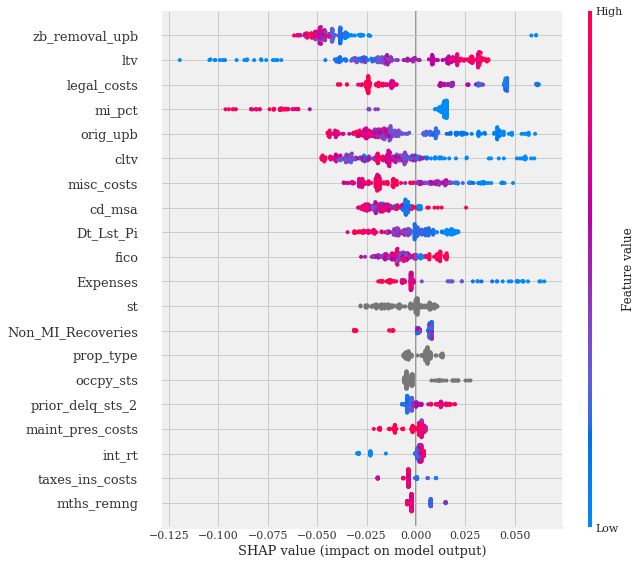

In [48]:
# Starting with Shap Values. Calculating each single contribution
import shap
shap_values = model.get_feature_importance(test_dataset, type="ShapValues")

shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, X_test1) 

In [89]:
# matplotlib settings
import matplotlib as mpl
plt.style.use(['seaborn-bright'])
mpl.rcParams['lines.linewidth'] = 2
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({
    "text.usetex": False})

%matplotlib inline

In [50]:

from sklearn import metrics


def get_feature_imp_plot(method):
    
#     if method == "Permutation":
#         fi =  permutation_importances(model, X_test1, y_test1, log_loss)
    
#     elif method == "Baseline":
#         fi = baseline_importance(model, X_train1, y_train1, X_test1, y_test1, log_loss)
    
#     elif method == "ShapeValues":
#         shap_values = model.get_feature_importance(Pool(X_test1, label=y_test1,cat_features=cat_features), 
#                                                                      type="ShapValues")
#         shap_values = shap_values[:,:-1]
#         shap.summary_plot(shap_values, X_test) 
        
#     else:
    fi = model.get_feature_importance(Pool(X_test1, label=y_test1,cat_features=cat_features), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_test1.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Testing set: Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

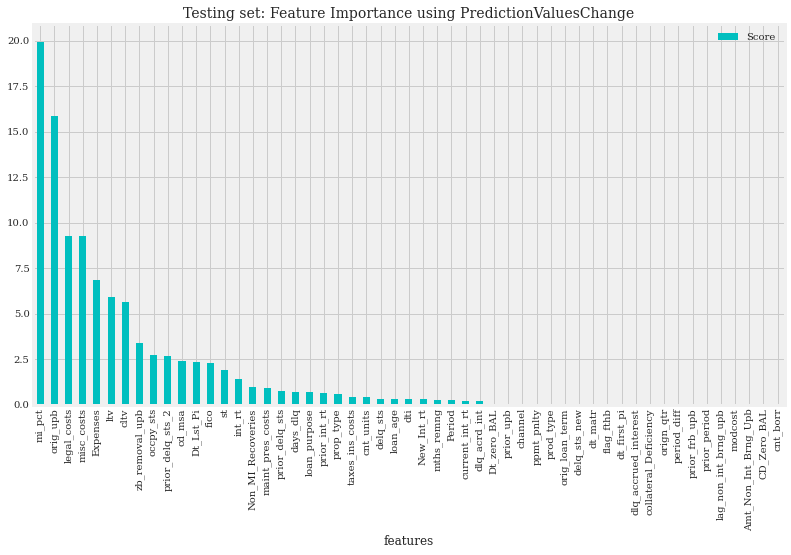

In [55]:
get_feature_imp_plot(method="PredictionValuesChange")

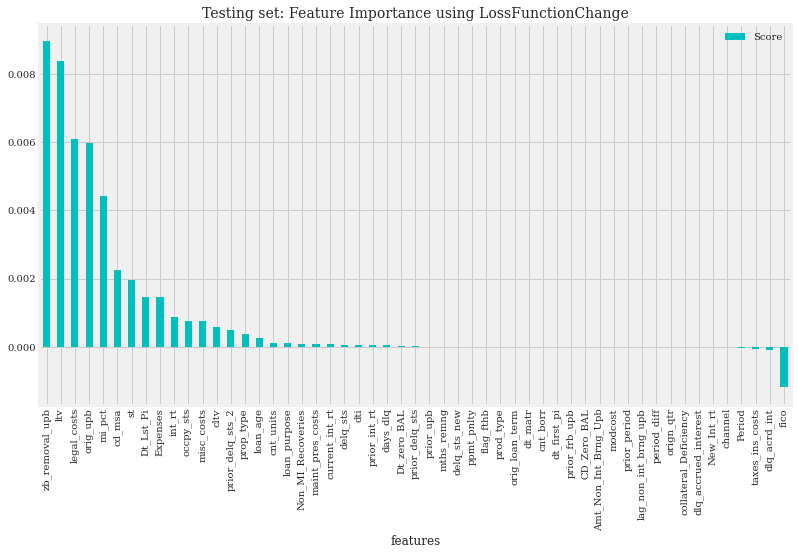

In [51]:
get_feature_imp_plot(method="LossFunctionChange")

In [53]:
def get_feature_imp_plot_train(method):
    

    fi = model.get_feature_importance(Pool(X_train1, label=y_train1,cat_features=cat_features), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_train1.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Training set: Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

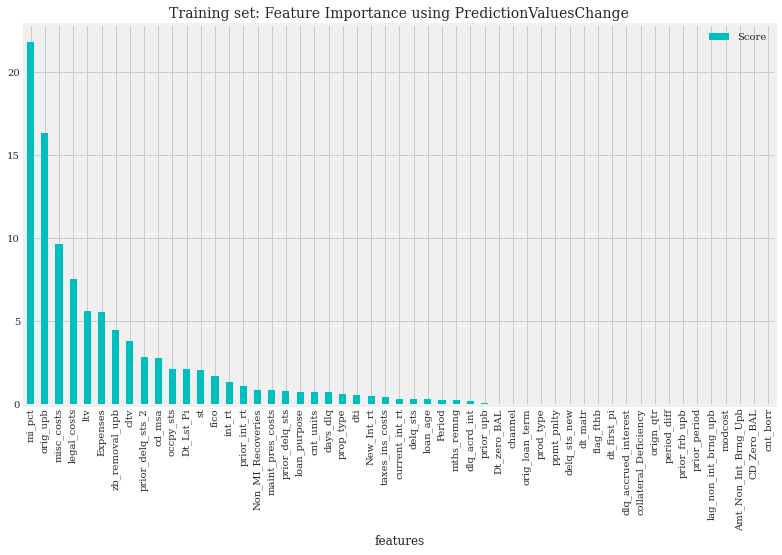

In [54]:
get_feature_imp_plot_train(method="PredictionValuesChange")

In [ ]:
get_feature_imp_plot_train(method="LossFunctionChange")

NameError: name 'get_feature_imp_plot_train' is not defined

In [ ]:
# Check the error distribution and then minimise the Huber function

# model_huber = CatBoostRegressor(iterations=1000,
#                           learning_rate=1,
#                           logging_level='Silent',
#                           loss_function='Huber',
#                           depth=2)


# # Fit model
# model_huber.fit(train_dataset, plot=True)
# # Get predictions
# preds_huber = model.predict(test_dataset)
clear_output()

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 49 kB/s 


In [3]:
# Mounting disk to save model logs 
from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install shap

     |████████████████████████████████| 356 kB 5.0 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491648 sha256=6a872593afd04f7def9e82fe7fd86df648f52c8721dc86d60a0aa86ab0a36733
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
